In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import t

In [2]:
# Function to extract epoch from the first few rows of the CSV file
def extract_epoch_from_header(file):
    # Read the first few lines to find the epoch (assuming it's in a comment or a header)
    with open(file, 'r') as f:
        skiprow = f.readline()
        skiprow = skiprow.strip().split()[0]
        for line in f:
            if "startdate:" in line.lower():  # Assuming the word 'epoch' is present in the line
                # Extract the epoch date (this assumes the date is the second item in the line)
                epoch = line.strip().split()[1]
                return int(skiprow)-1, epoch[0:4]+"-"+epoch[4:6]+"-"+epoch[6:8]+" "+epoch[8:10]+":"+epoch[10:12]+":"+epoch[12:14]
    return None  # Return None if no epoch is found

# Function to load and adjust time for each CSV
def load_and_adjust_time(file):
    # Try to extract the epoch from the header or a specific column
    nskiprows,epoch = extract_epoch_from_header(file)
   
    if epoch is None:
        raise ValueError(f"Could not find epoch for file: {file}")
   
    # Load the actual data (skipping header if necessary)
    df = pd.read_csv(file, skiprows=nskiprows,sep="\\s+")  # Adjust skiprows based on where the data starts
   
    # Convert 'time' column to a datetime, assuming it's in days
    # Adjust time column to start from the epoch time found in the file
    df['starttime_dt'] = pd.to_timedelta(df['starttime'], unit='D') + pd.Timestamp(epoch)
   
    # Return the adjusted DataFrame
    return df

In [3]:
#set a working directory till NMVOC folder
working_dir = "C:\\Year1\\"
# Find all CSV files (change the path if nedeed)
o3_files = glob.glob(working_dir+"NMVOC\\Data\\data_Ebas_O3\\*.nas")
print(o3_files)

# this function reads apropadjust times for all CSV files
dfs = []
for file in o3_files:
    df = load_and_adjust_time(file)
    dfs.append(df)

# concatenates all DataFrames (based on time)
#o3_df = pd.concat(dfs,axis=0,ignore_index=True)
o3_df=pd.concat(dfs).sort_values('starttime_dt').reset_index(drop=True)

# Show combined DataFrame
print(o3_df)

['C:\\Year1\\NMVOC\\Data\\data_Ebas_O3\\IT0009R.20110101000000.20191219000000.uv_abs.ozone.air.1y.1h.IT06L_1108.IT06L_49i_uvab.lev2.nas', 'C:\\Year1\\NMVOC\\Data\\data_Ebas_O3\\IT0009R.20111231230000.20200103115322.uv_abs.ozone.air.1y.1h.IT06L_CMN_49i_1225011092.IT06L_49i_uvab.lev2.nas', 'C:\\Year1\\NMVOC\\Data\\data_Ebas_O3\\IT0009R.20121231230000.20200103115322.uv_abs.ozone.air.1y.1h.IT06L_CMN_49i_1225011092.IT06L_49i_uvab.lev2.nas', 'C:\\Year1\\NMVOC\\Data\\data_Ebas_O3\\IT0009R.20131231230000.20200103115322.uv_abs.ozone.air.1y.1h.IT06L_CMN_49i_1225011092.IT06L_49i_uvab.lev2.nas', 'C:\\Year1\\NMVOC\\Data\\data_Ebas_O3\\IT0009R.20141231230000.20191217000000.uv_abs.ozone.air.1y.1h.IT06L_CMN_49i_1225011092.IT06L_49i_uvab.lev2.nas', 'C:\\Year1\\NMVOC\\Data\\data_Ebas_O3\\IT0009R.20160101000000.20181112095709.uv_abs.ozone.air.1y.1h.IT06L_CMN_49i_1225011092.IT06L_49i_uvab.lev2.nas', 'C:\\Year1\\NMVOC\\Data\\data_Ebas_O3\\IT0009R.20170101000000.20180311002000.uv_abs.ozone.air.1y.1h.IT06L_C

<Axes: >

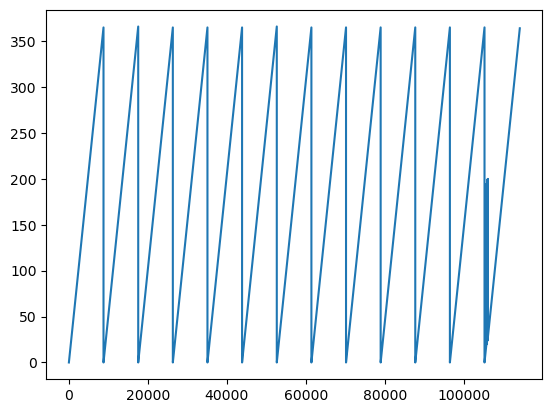

In [4]:

#verify the time column
o3_df["starttime"].plot()

In [60]:
#o3 [nmol/mol]
#remove lines depending on flags
o3_df = o3_df[o3_df.flag != 0.999]
o3_df = o3_df[o3_df.flag != 0.899]
o3_df = o3_df[o3_df.flag != 0.456]
o3_df = o3_df[o3_df.flag != 0.260]
o3_df = o3_df[o3_df.flag != 0.259]
o3_df = o3_df[o3_df.flag != 9.999]
o3_df = o3_df[o3_df['O3.1'] != 999.9]
o3_df = o3_df[o3_df.O3 != 999.99]

o3_df.index = o3_df["starttime_dt"]
#remove useless columns
o3_df = o3_df.drop(columns=["flag"])
o3_df = o3_df.drop(columns=["starttime"])
o3_df = o3_df.drop(columns=["endtime"])
o3_df = o3_df.drop(columns=["O3"])
o3_df = o3_df.drop(columns=["O3.2"])
o3_df = o3_df.drop(columns=["O3.3"])
o3_df = o3_df.drop(columns=["O3.4"])
o3_df = o3_df.drop(columns=["O3.5"])
o3_df = o3_df.drop(columns=["O3.6"])
o3_df = o3_df.drop(columns=["O3.7"])
#df = df.drop(columns=["starttime_dt"])
o3_df['O3_ppb']=o3_df['O3.1']
o3_df = o3_df.drop(columns=["O3.1"])
o3_df

,starttime_dt,O3_ppb
starttime_dt,,
2011-01-01 00:00:00.000000,2011-01-01 00:00:00.000000,46.2
2011-01-01 01:00:00.028800,2011-01-01 01:00:00.028800,46.1
2011-01-01 01:59:59.971200,2011-01-01 01:59:59.971200,46.3
2011-01-01 03:00:00.000000,2011-01-01 03:00:00.000000,45.7
2011-01-01 04:00:00.028800,2011-01-01 04:00:00.028800,45.6
...,...,...
2023-12-30 19:59:59.971200,2023-12-30 19:59:59.971200,42.3
2023-12-30 21:00:00.000000,2023-12-30 21:00:00.000000,41.9
2023-12-30 22:00:00.028800,2023-12-30 22:00:00.028800,42.2


In [61]:
o3_df.max()

starttime_dt    2023-12-31 00:00:00
O3_ppb                        103.3
dtype: object

In [62]:
#loop for rounding to the hours
o3_df["starttime_dt"] = [i.round("h") for i in o3_df["starttime_dt"]]
o3_df["datetime"]=o3_df["starttime_dt"]
o3_df = o3_df.drop(columns=["starttime_dt"])
o3_df.index = o3_df["datetime"]
o3_df

,O3_ppb,datetime
datetime,,
2011-01-01 00:00:00,46.2,2011-01-01 00:00:00
2011-01-01 01:00:00,46.1,2011-01-01 01:00:00
2011-01-01 02:00:00,46.3,2011-01-01 02:00:00
2011-01-01 03:00:00,45.7,2011-01-01 03:00:00
2011-01-01 04:00:00,45.6,2011-01-01 04:00:00
...,...,...
2023-12-30 20:00:00,42.3,2023-12-30 20:00:00
2023-12-30 21:00:00,41.9,2023-12-30 21:00:00
2023-12-30 22:00:00,42.2,2023-12-30 22:00:00


In [63]:
# Reset index and reformat DataFrame

o3_df = o3_df.drop(columns=["datetime"])
o3_df.head()

,O3_ppb
datetime,
2011-01-01 00:00:00,46.2
2011-01-01 01:00:00,46.1
2011-01-01 02:00:00,46.3
2011-01-01 03:00:00,45.7
2011-01-01 04:00:00,45.6


In [64]:
save_dir="C:\\YEAR1\\NMVOC\\Data\\" 

# Save final  DataFrame
output_file = os.path.join(save_dir, "processed_O3.csv")
o3_df.to_csv(output_file, index=True)

print(f"Saved final data to: {output_file}")

Saved final data to: C:\YEAR1\NMVOC\Data\processed_O3.csv


In [ ]:
o3_df.head(50)

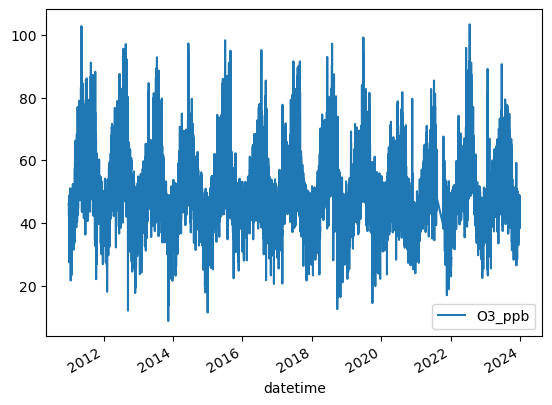

In [65]:
o3_df.plot()

plt.show()